In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot

Loading VIX from c:\Users\Nils\Desktop\Investment dashboard\VIX.csv
Loaded and aligned returns. Date range: 2012-07-09 00:00:00 to 2026-02-06 00:00:00

Daily returns (head):
        Date  MSCI_World  EEM_ETF    Gold    VIX
0 2012-07-09     -0.0043  -0.0036  0.0027  17.98
1 2012-07-10     -0.0044  -0.0112 -0.0130  18.72
2 2012-07-11      0.0000   0.0053  0.0066  17.95
3 2012-07-12     -0.0093  -0.0168 -0.0029  18.33
4 2012-07-13      0.0150   0.0192  0.0106  16.74

Cumulative values (head):
        Date  MSCI_World_Value  EEM_ETF_Value  Gold_Value
0 2012-07-09         99.570000      99.640000  100.270000
1 2012-07-10         99.131892      98.524032   98.966490
2 2012-07-11         99.131892      99.046209   99.619669
3 2012-07-12         98.209965      97.382233   99.330772
4 2012-07-13         99.683115      99.251972  100.383678


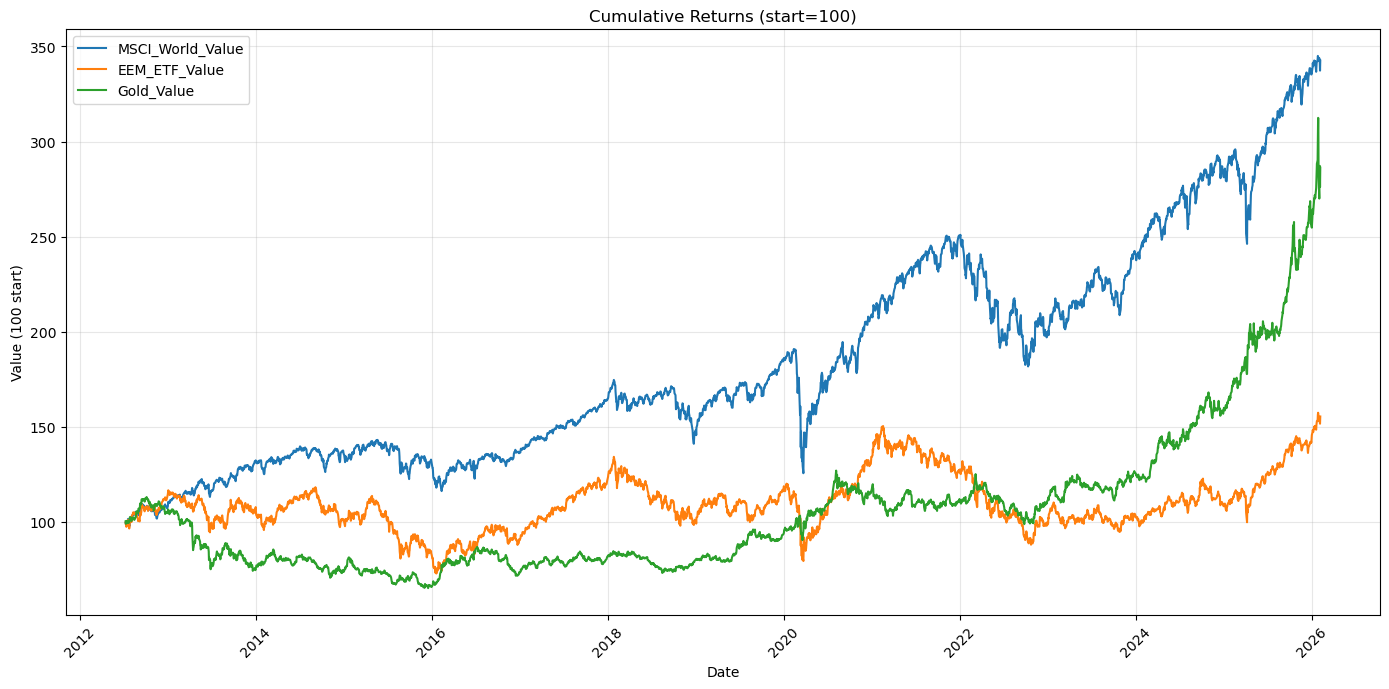

In [161]:
# Load three time series, extract daily returns (decimals), build cumulative series starting at 100, load VIX, and plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

files = {
    'MSCI_World': 'MSCI World Historical Data.csv',
    'EEM_ETF': 'EEM ETF Stock Price History.csv',
    'Gold': 'XAU_USD Historical Data.csv'
}

asset_returns = {}
for name, path in files.items():
    df_a = pd.read_csv(path)
    # Normalize column names
    df_a.columns = [c.strip() for c in df_a.columns]
    # Parse date
    if 'Date' in df_a.columns:
        df_a['Date'] = pd.to_datetime(df_a['Date'])
    # Determine returns source
    if 'Change %' in df_a.columns:
        # e.g. "1.56%"
        df_a['Daily_Return'] = df_a['Change %'].astype(str).str.rstrip('%').str.replace(',','').astype(float) / 100
    elif 'Change' in df_a.columns and df_a['Change'].dtype == object:
        df_a['Daily_Return'] = df_a['Change'].astype(str).str.rstrip('%').str.replace(',','').astype(float) / 100
    else:
        # Try to use 'Price' or 'Close'
        price_col = None
        for candidate in ['Price', 'Close', 'Adj Close', 'AdjClose']:
            if candidate in df_a.columns:
                price_col = candidate
                break
        if price_col is None:
            # fallback: take the first numeric column other than date
            numeric_cols = df_a.select_dtypes(include=[np.number]).columns.tolist()
            numeric_cols = [c for c in numeric_cols if c.lower() not in ['vol', 'volume']]
            price_col = numeric_cols[0] if numeric_cols else None
        if price_col is None:
            raise ValueError(f"No price or change column found in {path}")
        # remove thousand separators if string
        if df_a[price_col].dtype == object:
            df_a[price_col] = df_a[price_col].astype(str).str.replace(',','')
        df_a[price_col] = pd.to_numeric(df_a[price_col], errors='coerce')
        df_a = df_a.sort_values('Date')
        df_a['Daily_Return'] = df_a[price_col].pct_change()
    # Keep needed columns
    asset_returns[name] = df_a[['Date', 'Daily_Return']].copy()

# Merge on Date (inner join to keep aligned trading days)
merged = None
for name, df_r in asset_returns.items():
    df_r = df_r.rename(columns={'Daily_Return': name})
    if merged is None:
        merged = df_r
    else:
        merged = merged.merge(df_r, on='Date', how='inner')

merged = merged.sort_values('Date').reset_index(drop=True)

# Drop rows with NA in any returns
merged = merged.dropna().reset_index(drop=True)

# --- Load VIX CSV explicitly and robustly ---
vix_path = r'c:\Users\Nils\Desktop\Investment dashboard\VIX.csv'
if not os.path.exists(vix_path):
    raise FileNotFoundError(f"VIX file not found at {vix_path}. Please place the file there or update the path.")

print('Loading VIX from', vix_path)
df_vix = pd.read_csv(vix_path)
# normalize column names
df_vix.columns = [c.strip() for c in df_vix.columns]

# Robust date-column detection/parsing
date_col = None
for c in df_vix.columns:
    if 'date' in c.strip().lower():
        date_col = c
        break
if date_col is None:
    # try to parse the first column as date
    first_col = df_vix.columns[0]
    try:
        parsed_try = pd.to_datetime(df_vix[first_col], errors='coerce')
        if parsed_try.notna().any():
            date_col = first_col
    except Exception:
        date_col = None

if date_col is None:
    raise ValueError('No date-like column found in VIX file; please ensure there is a date column.')

# create standardized 'Date' column
df_vix['Date'] = pd.to_datetime(df_vix[date_col], errors='coerce')
if df_vix['Date'].isna().all():
    raise ValueError('Could not parse any dates in VIX file; check date formats.')

# find a VIX value column
vix_col = None
for candidate in ['VIX', 'Close', 'Price', 'Adj Close', 'AdjClose']:
    if candidate in df_vix.columns:
        vix_col = candidate
        break
if vix_col is None:
    numeric_cols = df_vix.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude the detected date column if it's numeric
    numeric_cols = [c for c in numeric_cols if c != date_col]
    vix_col = numeric_cols[0] if numeric_cols else None
if vix_col is None:
    raise ValueError('No numeric column found in VIX file to use as VIX level')

# Keep only Date and VIX
df_vix = df_vix[['Date', vix_col]].rename(columns={vix_col: 'VIX'})
df_vix = df_vix.sort_values('Date').reset_index(drop=True)

# Merge VIX into merged on Date (left join — keep merged dates)
merged = merged.merge(df_vix, on='Date', how='left')

# Build cumulative value series starting at 100
cum = pd.DataFrame({'Date': merged['Date']})
for name in files.keys():
    cum[name + '_Value'] = (1 + merged[name]).cumprod() * 100

# Display
print('Loaded and aligned returns. Date range:', merged['Date'].min(), 'to', merged['Date'].max())
print('\nDaily returns (head):')
print(merged.head())
print('\nCumulative values (head):')
print(cum.head())

# Plot cumulative values
plt.figure(figsize=(14,7))
for col in cum.columns:
    if col == 'Date':
        continue
    plt.plot(cum['Date'], cum[col], label=col)
plt.title('Cumulative Returns (start=100)')
plt.xlabel('Date')
plt.ylabel('Value (100 start)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

SINGLE-ASSET STRATEGIES: MSCI World with 6 leverage approaches (monthly rebal)

Unlevered:
  CAGR: 0.0893
  Annual_Vol: 0.1456
  Sharpe: 0.6137
  Max_DD: -0.342

1.5x Fixed Leverage:
  CAGR: 0.1278
  Annual_Vol: 0.2184
  Sharpe: 0.5854
  Max_DD: -0.4754

2x Fixed Leverage:
  CAGR: 0.1613
  Annual_Vol: 0.2911
  Sharpe: 0.5541
  Max_DD: -0.5871

Realized-Vol Z-score Leverage (dynamic, max 2x):
  Time-weighted avg leverage: 1.4504
  CAGR: 0.14
  Annual_Vol: 0.1875
  Sharpe: 0.7468
  Max_DD: -0.4235

Implied-Vol (VIX) Z-score Leverage (dynamic, max 2x):
  Time-weighted avg leverage: 1.4055
  CAGR: 0.1174
  Annual_Vol: 0.1819
  Sharpe: 0.6454
  Max_DD: -0.3568

Min(Realized, Implied) Z-score Leverage (conservative, max 2x):
  Time-weighted avg leverage: 1.2856
  CAGR: 0.1225
  Annual_Vol: 0.1671
  Sharpe: 0.7331
  Max_DD: -0.3568


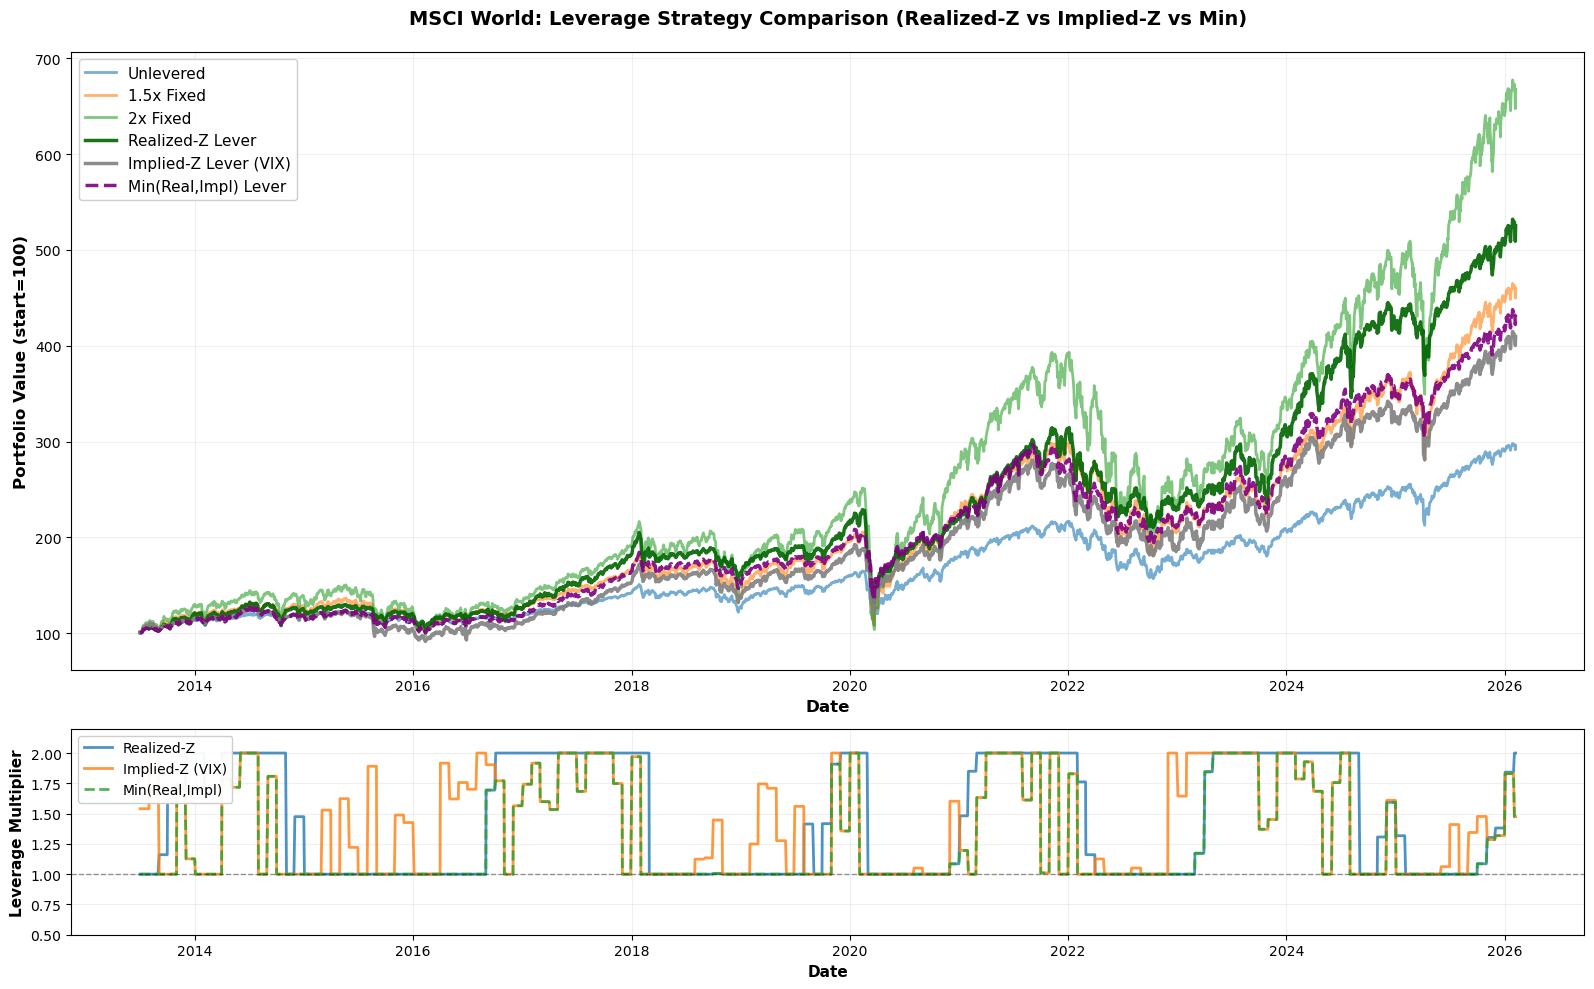

In [184]:
# Compare strategies: Unlevered, 1.5x, 2x, Realized-Z, Implied-Z (VIX), and Min-of-Both (monthly rebal)
import matplotlib.pyplot as plt

# Prepare dataframe with returns
strat = merged[['Date', 'MSCI_World', 'VIX']].copy()
strat = strat.sort_values('Date').reset_index(drop=True)
strat["VIX"]   = strat["VIX"].ffill()

# Compute EWMA volatility
ewm_std_smooth = strat['MSCI_World'].ewm(span=252, adjust=False).std()
vol_ewma_smooth = ewm_std_smooth * np.sqrt(252)

# Backward-looking z-score with 250-day rolling window (Realized-Vol based)
rolling_mean = vol_ewma_smooth.rolling(window=250).mean()
rolling_std = vol_ewma_smooth.rolling(window=250).std()
zscore_realized = (vol_ewma_smooth - rolling_mean) / rolling_std

# Implied (VIX) z-score using VIX level
vix_ewm = strat['VIX']#.ewm(span=10, adjust=False).mean()  # short smoothing for IV
vix_roll_mean = vix_ewm.rolling(window=252).mean()
vix_roll_std = vix_ewm.rolling(window=252).std()
zscore_implied = (vix_ewm - vix_roll_mean) / vix_roll_std

# Monthly rebalancing: determine leverage at month-start, apply for entire month
strat['Month'] = strat['Date'].dt.to_period('M')

# Map to leverage rule: if z>0 -> 1.0 else min(1.0 - z, 2.0)
lev_realized = np.where(zscore_realized > 0, 1.0, np.minimum(1.0 - zscore_realized, 2.0))
lev_implied = np.where(zscore_implied > 0, 1.0, np.minimum(1.0 - zscore_implied, 2.0))


lev_min = np.minimum(lev_realized, lev_implied)

strat['Leverage_Realized'] = lev_realized
strat['Leverage_Implied'] = lev_implied
strat['Leverage_Min'] = lev_min

# Set leverage to value at start of each month and hold it for entire month
strat['Leverage_Realized_MonthlyReb'] = strat.groupby('Month')['Leverage_Realized'].transform('first')
strat['Leverage_Implied_MonthlyReb'] = strat.groupby('Month')['Leverage_Implied'].transform('first')
strat['Leverage_Min_MonthlyReb'] = strat.groupby('Month')['Leverage_Min'].transform('first')

# Strategy returns
strat['Return_Unlevered'] = strat['MSCI_World']
strat['Return_1_5x'] = 1.5 * strat['MSCI_World']
strat['Return_2x'] = 2.0 * strat['MSCI_World']
strat['Return_Realized'] = strat['Leverage_Realized_MonthlyReb'] * strat['MSCI_World']
strat['Return_Implied'] = strat['Leverage_Implied_MonthlyReb'] * strat['MSCI_World']
strat['Return_Min'] = strat['Leverage_Min_MonthlyReb'] * strat['MSCI_World']

# Find first valid index where leverages are not NaN
first_valid_idx = strat[['Leverage_Realized_MonthlyReb', 'Leverage_Implied_MonthlyReb', 'Leverage_Min_MonthlyReb']].dropna(how='all').index.min()

# Create a subset starting from the first valid point
strat_aligned = strat.loc[first_valid_idx:].copy()

# Compute cumulative values starting at 100
strat_aligned['Value_Unlevered'] = (1 + strat_aligned['Return_Unlevered']).cumprod() * 100
strat_aligned['Value_1_5x'] = (1 + strat_aligned['Return_1_5x']).cumprod() * 100
strat_aligned['Value_2x'] = (1 + strat_aligned['Return_2x']).cumprod() * 100
strat_aligned['Value_Realized'] = (1 + strat_aligned['Return_Realized']).cumprod() * 100
strat_aligned['Value_Implied'] = (1 + strat_aligned['Return_Implied']).cumprod() * 100
strat_aligned['Value_Min'] = (1 + strat_aligned['Return_Min']).cumprod() * 100

# Performance metrics helper
def metrics(returns_series):
    days = returns_series.shape[0]
    daily_ret = returns_series.pct_change().dropna()
    ann_vol = daily_ret.std() * np.sqrt(252)
    ann_ret = (returns_series.iloc[-1] / returns_series.iloc[0]) ** (252 / days) - 1
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    peak = returns_series.cummax()
    dd = (returns_series - peak) / peak
    max_dd = dd.min()
    return {'CAGR': round(ann_ret,4), 'Annual_Vol': round(ann_vol,4), 'Sharpe': round(sharpe,4), 'Max_DD': round(max_dd,4)}

print('='*90)
print('SINGLE-ASSET STRATEGIES: MSCI World with 6 leverage approaches (monthly rebal)')
print('='*90)

print('\nUnlevered:')
for k,v in metrics(strat_aligned['Value_Unlevered']).items():
    print(f"  {k}: {v}")

print('\n1.5x Fixed Leverage:')
for k,v in metrics(strat_aligned['Value_1_5x']).items():
    print(f"  {k}: {v}")

print('\n2x Fixed Leverage:')
for k,v in metrics(strat_aligned['Value_2x']).items():
    print(f"  {k}: {v}")

print('\nRealized-Vol Z-score Leverage (dynamic, max 2x):')
print(f'  Time-weighted avg leverage: {round(strat_aligned["Leverage_Realized_MonthlyReb"].mean(), 4)}')
for k,v in metrics(strat_aligned['Value_Realized']).items():
    print(f"  {k}: {v}")

print('\nImplied-Vol (VIX) Z-score Leverage (dynamic, max 2x):')
print(f'  Time-weighted avg leverage: {round(strat_aligned["Leverage_Implied_MonthlyReb"].mean(), 4)}')
for k,v in metrics(strat_aligned['Value_Implied']).items():
    print(f"  {k}: {v}")

print('\nMin(Realized, Implied) Z-score Leverage (conservative, max 2x):')
print(f'  Time-weighted avg leverage: {round(strat_aligned["Leverage_Min_MonthlyReb"].mean(), 4)}')
for k,v in metrics(strat_aligned['Value_Min']).items():
    print(f"  {k}: {v}")

# Plot all 6 strategies with leverage visualization
fig, (ax, ax_lev) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

# Main plot: strategies
ax.plot(strat_aligned['Date'], strat_aligned['Value_Unlevered'], label='Unlevered', linewidth=2, alpha=0.6)
ax.plot(strat_aligned['Date'], strat_aligned['Value_1_5x'], label='1.5x Fixed', linewidth=2, alpha=0.6)
ax.plot(strat_aligned['Date'], strat_aligned['Value_2x'], label='2x Fixed', linewidth=2, alpha=0.6)
ax.plot(strat_aligned['Date'], strat_aligned['Value_Realized'], label='Realized-Z Lever', linewidth=2.5, alpha=0.9, color='darkgreen')
ax.plot(strat_aligned['Date'], strat_aligned['Value_Implied'], label='Implied-Z Lever (VIX)', linewidth=2.5, alpha=0.9, color='grey')
ax.plot(strat_aligned['Date'], strat_aligned['Value_Min'], label='Min(Real,Impl) Lever', linewidth=2.5, alpha=0.9, color='purple', linestyle='--')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Portfolio Value (start=100)', fontsize=12, fontweight='bold')
ax.set_title('MSCI World: Leverage Strategy Comparison (Realized-Z vs Implied-Z vs Min)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(alpha=0.2)

# Leverage plot
ax_lev.plot(strat_aligned['Date'], strat_aligned['Leverage_Realized_MonthlyReb'], label='Realized-Z', linewidth=2, alpha=0.8)
ax_lev.plot(strat_aligned['Date'], strat_aligned['Leverage_Implied_MonthlyReb'], label='Implied-Z (VIX)', linewidth=2, alpha=0.8)
ax_lev.plot(strat_aligned['Date'], strat_aligned['Leverage_Min_MonthlyReb'], label='Min(Real,Impl)', linewidth=2, linestyle='--', alpha=0.8)
ax_lev.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.4)
ax_lev.set_ylabel('Leverage Multiplier', fontsize=11, fontweight='bold')
ax_lev.set_xlabel('Date', fontsize=11, fontweight='bold')
ax_lev.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax_lev.grid(alpha=0.2)
ax_lev.set_ylim(0.5, 2.2)

plt.tight_layout()
plt.show()


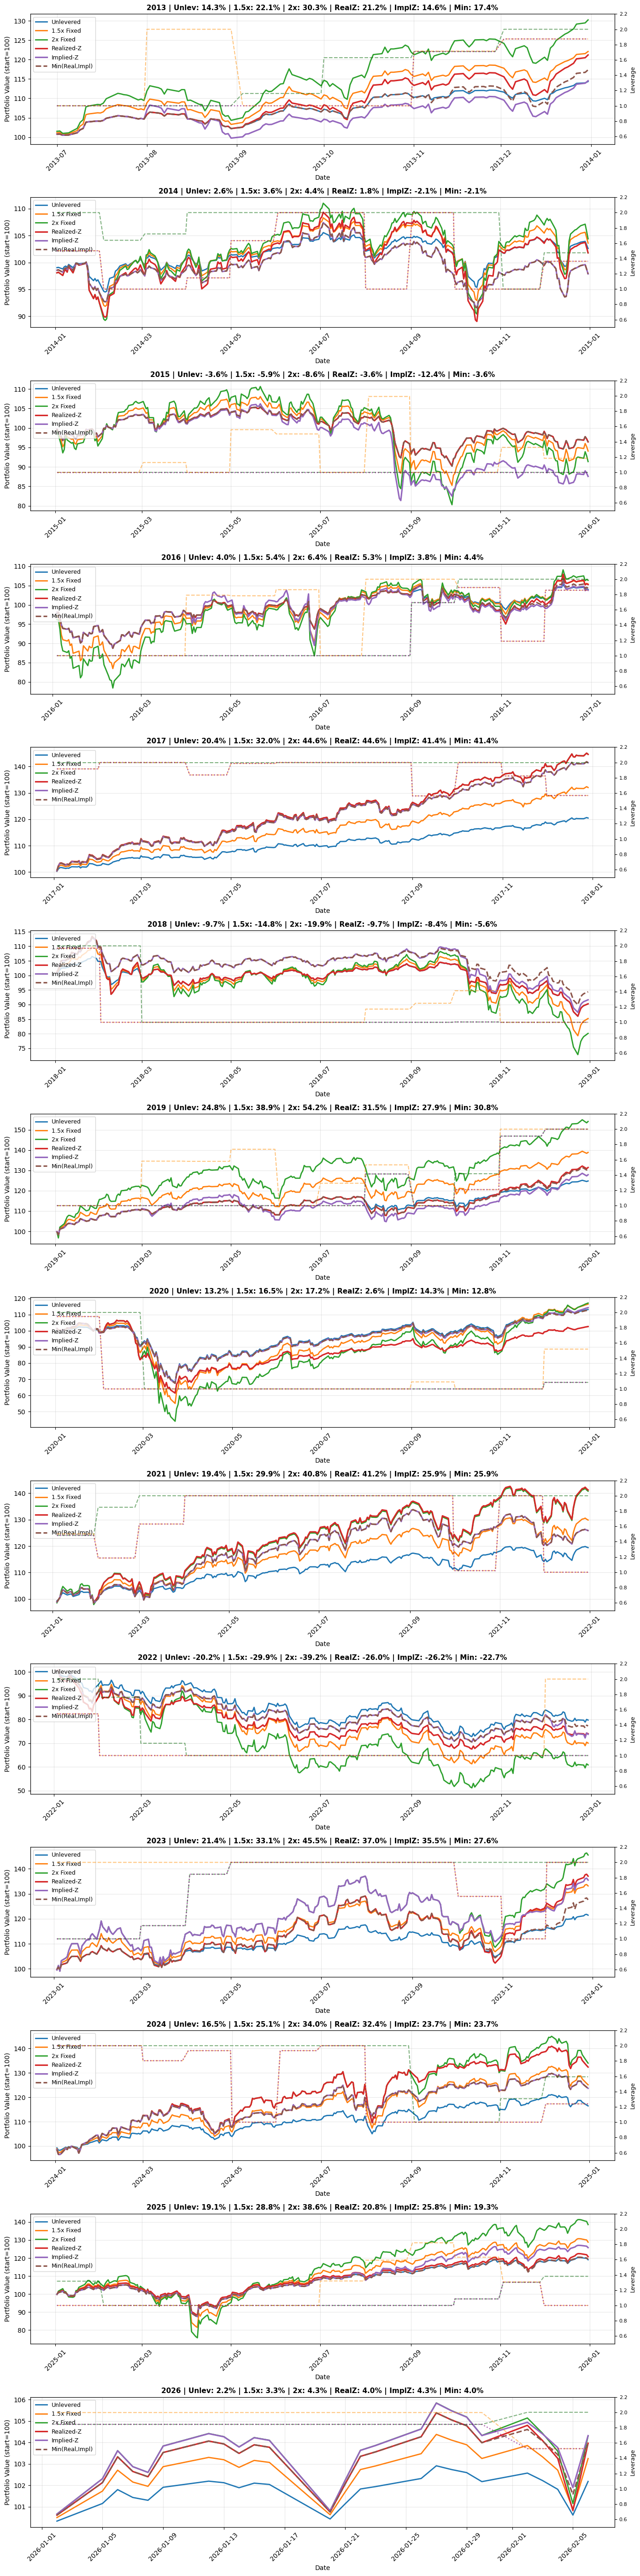

In [174]:
# Plot each year separately - one plot per year (aligned with realized / implied / min strategies)
import matplotlib.pyplot as plt

# Extract unique years
years = sorted(strat_aligned['Date'].dt.year.unique())
n_years = len(years)

# Create subplots (one per year, stacked vertically)
fig, axes = plt.subplots(n_years, 1, figsize=(14, 4 * n_years))
if n_years == 1:
    axes = [axes]

# Plot each year
for idx, year in enumerate(years):
    ax = axes[idx]

    year_mask = strat_aligned['Date'].dt.year == year
    year_data = strat_aligned.loc[year_mask].copy()

    # Reset values to 100 at start of year
    year_data['Value_Unlevered'] = (1 + year_data['Return_Unlevered']).cumprod() * 100
    year_data['Value_1_5x'] = (1 + year_data['Return_1_5x']).cumprod() * 100
    year_data['Value_2x'] = (1 + year_data['Return_2x']).cumprod() * 100
    year_data['Value_Realized'] = (1 + year_data['Return_Realized']).cumprod() * 100
    year_data['Value_Implied'] = (1 + year_data['Return_Implied']).cumprod() * 100
    year_data['Value_Min'] = (1 + year_data['Return_Min']).cumprod() * 100

    # Secondary axis: leverage (monthly rebalanced)
    ax2 = ax.twinx()
    ax2.plot(
        year_data['Date'],
        year_data['Leverage_Realized_MonthlyReb'],
        label='Realized-Z Lev',
        color='darkgreen',
        linestyle='--',
        linewidth=1.5,
        alpha=0.5
    )
    ax2.plot(
        year_data['Date'],
        year_data['Leverage_Implied_MonthlyReb'],
        label='Implied-Z Lev',
        color='darkorange',
        linestyle='--',
        linewidth=1.5,
        alpha=0.5
    )
    ax2.plot(
        year_data['Date'],
        year_data['Leverage_Min_MonthlyReb'],
        label='Min(Real,Impl)',
        color='purple',
        linestyle=':',
        linewidth=1.8,
        alpha=0.6
    )

    ax2.set_ylabel('Leverage', fontsize=9)
    ax2.set_ylim(0.5, 2.2)
    ax2.tick_params(axis='y', labelsize=8)

    # Main performance plots
    ax.plot(year_data['Date'], year_data['Value_Unlevered'], label='Unlevered', linewidth=2)
    ax.plot(year_data['Date'], year_data['Value_1_5x'], label='1.5x Fixed', linewidth=2)
    ax.plot(year_data['Date'], year_data['Value_2x'], label='2x Fixed', linewidth=2)
    ax.plot(year_data['Date'], year_data['Value_Realized'], label='Realized-Z', linewidth=2.3)
    ax.plot(year_data['Date'], year_data['Value_Implied'], label='Implied-Z', linewidth=2.3)
    ax.plot(year_data['Date'], year_data['Value_Min'], label='Min(Real,Impl)', linewidth=2.3, linestyle='--')

    # Yearly returns (from 100 base)
    yr_ret = lambda s: (s.iloc[-1] / 100) - 1

    title = (
        f"{year} | "
        f"Unlev: {yr_ret(year_data['Value_Unlevered']):.1%} | "
        f"1.5x: {yr_ret(year_data['Value_1_5x']):.1%} | "
        f"2x: {yr_ret(year_data['Value_2x']):.1%} | "
        f"RealZ: {yr_ret(year_data['Value_Realized']):.1%} | "
        f"ImplZ: {yr_ret(year_data['Value_Implied']):.1%} | "
        f"Min: {yr_ret(year_data['Value_Min']):.1%}"
    )

    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Portfolio Value (start=100)', fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


PORTFOLIO COMPARISON: MSCI/Gold with Fixed + Z-Score Leverage

70-30 Allocation
------------------------------------------------------------
  Unlevered:
    CAGR: 0.0992
    Annual_Vol: 0.114
    Sharpe: 0.8695
    Max_DD: -0.2548
  1_5x:
    CAGR: 0.129
    Annual_Vol: 0.1613
    Sharpe: 0.8002
    Max_DD: -0.3577
  2x:
    CAGR: 0.1567
    Annual_Vol: 0.2099
    Sharpe: 0.7467
    Max_DD: -0.4493
  RealizedLev:
    CAGR: 0.1364
    Annual_Vol: 0.1415
    Sharpe: 0.9639
    Max_DD: -0.3183
  ImpliedLev:
    CAGR: 0.1181
    Annual_Vol: 0.1394
    Sharpe: 0.8474
    Max_DD: -0.2686
  MinLev:
    CAGR: 0.1235
    Annual_Vol: 0.1297
    Sharpe: 0.9519
    Max_DD: -0.2686

75-25 Allocation
------------------------------------------------------------
  Unlevered:
    CAGR: 0.0978
    Annual_Vol: 0.1175
    Sharpe: 0.8318
    Max_DD: -0.2695
  1_5x:
    CAGR: 0.1293
    Annual_Vol: 0.1694
    Sharpe: 0.763
    Max_DD: -0.378
  2x:
    CAGR: 0.1582
    Annual_Vol: 0.2223
    Sharpe: 0.7117


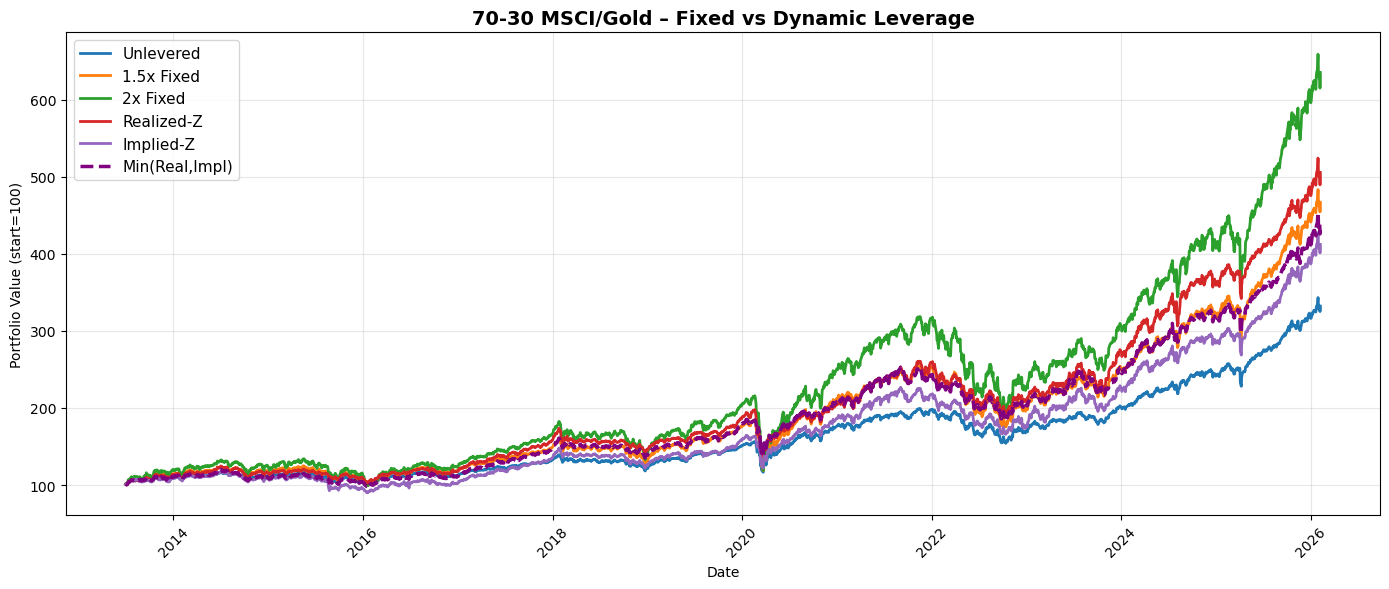

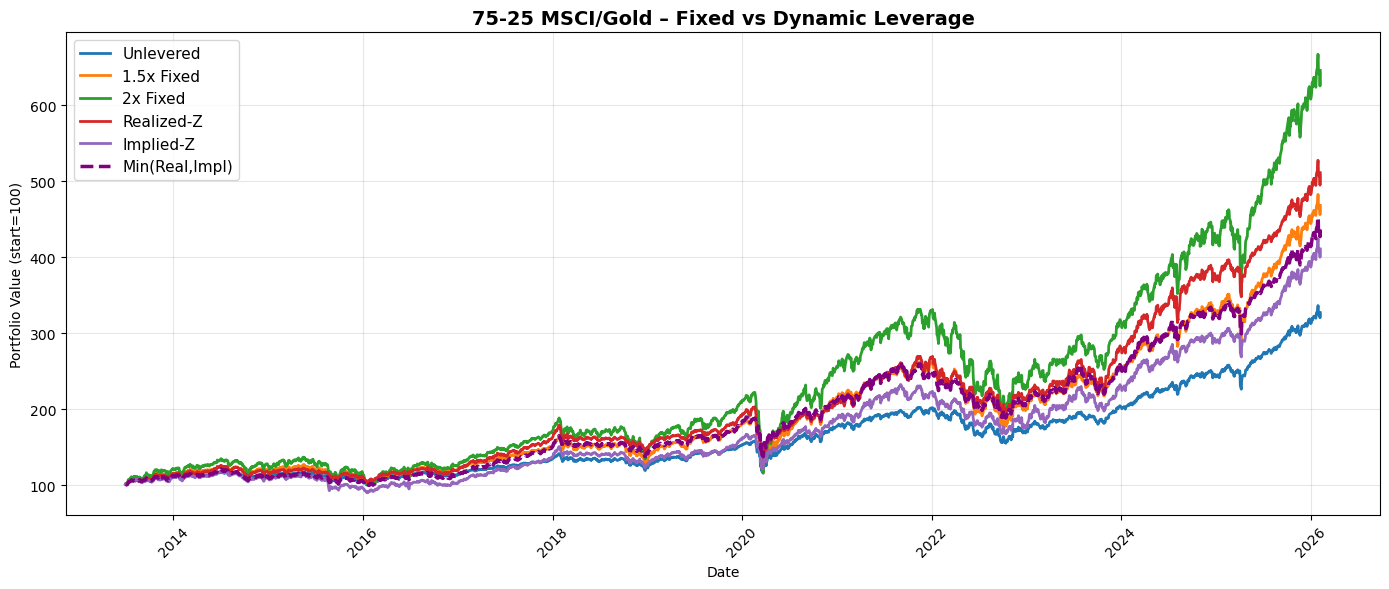

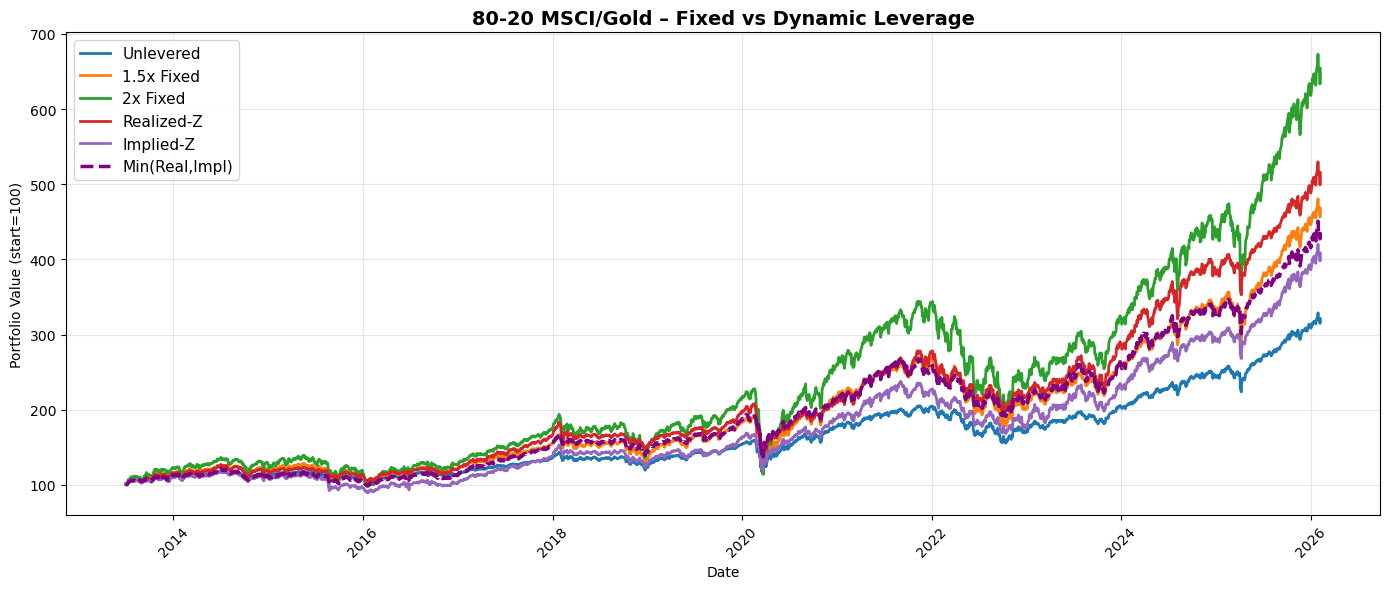


Done.


In [176]:
# ============================================================
# Portfolio comparison incl. fixed 1.5x & 2x leverage
# ============================================================
import matplotlib.pyplot as plt

# Allocations to compare
allocations = {
    '70-30': {'msci': 0.70, 'gold': 0.30},
    '75-25': {'msci': 0.75, 'gold': 0.25},
    '80-20': {'msci': 0.80, 'gold': 0.20},
}

# Prepare portfolio data
portfolio_data = merged[['Date', 'MSCI_World', 'Gold', 'VIX']].copy()
portfolio_data = portfolio_data.sort_values('Date').reset_index(drop=True)

# ---------- Z-scores ----------
ewm_std = portfolio_data['MSCI_World'].ewm(span=252, adjust=False).std()
vol_ewma = ewm_std * np.sqrt(252)
real_mean = vol_ewma.rolling(250).mean()
real_std = vol_ewma.rolling(250).std()
real_z = (vol_ewma - real_mean) / real_std

vix_ewm = portfolio_data['VIX'].ewm(span=10, adjust=False).mean()
vix_mean = vix_ewm.rolling(252).mean()
vix_std = vix_ewm.rolling(252).std()
vix_z = (vix_ewm - vix_mean) / vix_std

lev_real = np.where(real_z > 0, 1.0, np.minimum(1.0 - real_z, 2.0))
lev_impl = np.where(vix_z > 0, 1.0, np.minimum(1.0 - vix_z, 2.0))

portfolio_data['Leverage_Realized'] = lev_real
portfolio_data['Leverage_Implied'] = lev_impl

portfolio_data['Month'] = portfolio_data['Date'].dt.to_period('M')
portfolio_data['Lev_Real_M'] = portfolio_data.groupby('Month')['Leverage_Realized'].transform('first')
portfolio_data['Lev_Impl_M'] = portfolio_data.groupby('Month')['Leverage_Implied'].transform('first')

first_valid = portfolio_data[['Lev_Real_M', 'Lev_Impl_M']].dropna(how='all').index.min()
portfolio = portfolio_data.loc[first_valid:].copy()

# ---------- Portfolio simulation ----------
for name, w in allocations.items():
    w_m, w_g = w['msci'], w['gold']

    ret_un, ret_15, ret_2 = [], [], []
    ret_real, ret_impl, ret_min = [], [], []

    port_m, port_g = 100 * w_m, 100 * w_g
    current_month = None

    for _, row in portfolio.iterrows():
        date = row['Date']
        month = date.to_period('M')

        r_m = row['MSCI_World']
        r_g = row['Gold']

        lev_r = 1.0 if pd.isna(row['Lev_Real_M']) else row['Lev_Real_M']
        lev_i = 1.0 if pd.isna(row['Lev_Impl_M']) else row['Lev_Impl_M']
        lev_min = min(lev_r, lev_i)

        # monthly rebalance
        if current_month != month:
            current_month = month
            tot = port_m + port_g
            port_m, port_g = tot * w_m, tot * w_g

        tot = port_m + port_g

        # returns
        ret_un.append((port_m * r_m + port_g * r_g) / tot)
        ret_15.append((1.5 * port_m * r_m + port_g * r_g) / tot)
        ret_2.append((2.0 * port_m * r_m + port_g * r_g) / tot)
        ret_real.append((lev_r * port_m * r_m + port_g * r_g) / tot)
        ret_impl.append((lev_i * port_m * r_m + port_g * r_g) / tot)
        ret_min.append((lev_min * port_m * r_m + port_g * r_g) / tot)

        port_m *= (1 + r_m)
        port_g *= (1 + r_g)

    # store
    for label, series in {
        'Unlevered': ret_un,
        '1_5x': ret_15,
        '2x': ret_2,
        'RealizedLev': ret_real,
        'ImpliedLev': ret_impl,
        'MinLev': ret_min
    }.items():
        portfolio[f'Return_{name}_{label}'] = series
        portfolio[f'Value_{name}_{label}'] = (1 + portfolio[f'Return_{name}_{label}']).cumprod() * 100

# ---------- Metrics ----------
print('='*90)
print('PORTFOLIO COMPARISON: MSCI/Gold with Fixed + Z-Score Leverage')
print('='*90)

for name in allocations:
    print(f'\n{name} Allocation')
    print('-'*60)
    for label in ['Unlevered', '1_5x', '2x', 'RealizedLev', 'ImpliedLev', 'MinLev']:
        print(f'  {label}:')
        for k, v in metrics(portfolio[f'Value_{name}_{label}']).items():
            print(f'    {k}: {v}')

# ---------- Plots ----------
for name in allocations:
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_Unlevered'], label='Unlevered', lw=2)
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_1_5x'], label='1.5x Fixed', lw=2)
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_2x'], label='2x Fixed', lw=2)
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_RealizedLev'], label='Realized-Z', lw=2)
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_ImpliedLev'], label='Implied-Z', lw=2)
    ax.plot(portfolio['Date'], portfolio[f'Value_{name}_MinLev'], label='Min(Real,Impl)', lw=2.5, ls='--', color='purple')

    ax.set_title(f'{name} MSCI/Gold – Fixed vs Dynamic Leverage', fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Value (start=100)')
    ax.set_xlabel('Date')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print('\nDone.')


In [21]:
import pandas as pd

sp_path = "S&P 500 Historical Data.csv"
fx_path = "EUR_USD Historical Data.csv"
out_path = "S&P 500 Historical Data (EUR).csv"

def to_numeric(series):
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce")

# Load
sp = pd.read_csv(sp_path)
fx = pd.read_csv(fx_path)

# Parse dates (Investing.com format)
sp["Date"] = pd.to_datetime(sp["Date"], format="%m/%d/%Y", errors="coerce")
fx["Date"] = pd.to_datetime(fx["Date"], format="%m/%d/%Y", errors="coerce")

# Numeric prices
for col in ["Price", "Open", "High", "Low"]:
    if col in sp.columns:
        sp[col] = to_numeric(sp[col])

fx["Price"] = to_numeric(fx["Price"])  # USD per EUR
fx["EUR_per_USD"] = 1.0 / fx["Price"]

# Merge and convert to EUR
merged = sp.merge(fx[["Date", "EUR_per_USD"]], on="Date", how="left")

for col in ["Price", "Open", "High", "Low"]:
    if col in merged.columns:
        merged[col] = merged[col] * merged["EUR_per_USD"]

# Recompute Change % from EUR Price
merged = merged.sort_values("Date")
merged["Change %"] = merged["Price"].pct_change() * 100
merged["Change %"] = merged["Change %"].round(2).map(lambda x: f"{x:.2f}%" if pd.notna(x) else "")

# Restore original column order
cols = ["Date", "Price", "Open", "High", "Low", "Vol.", "Change %"]
merged = merged[cols].sort_index(ascending=True)

# Save
merged.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: S&P 500 Historical Data (EUR).csv


<Axes: >

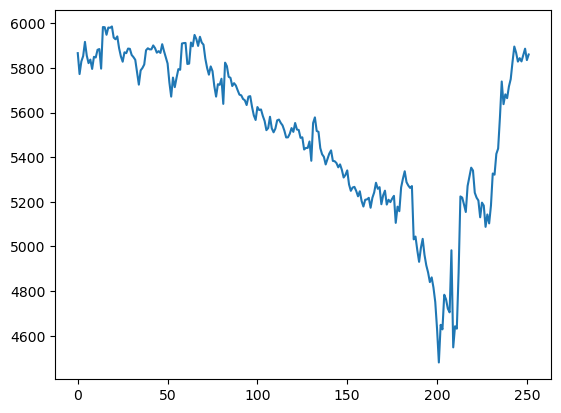

In [25]:
merged["Price"].iloc[:252].plot()

<Axes: >

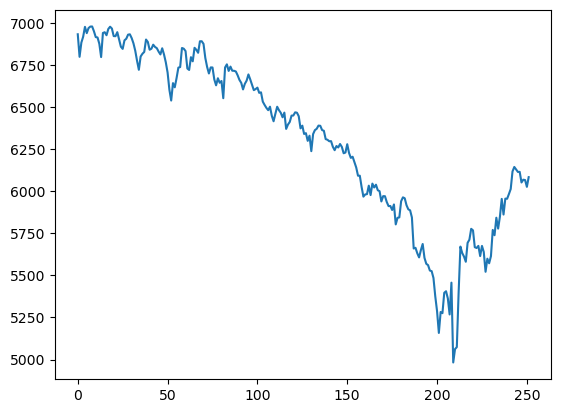

In [26]:
sp["Price"].iloc[:252].plot()